In [ ]:
! pip install -q sklearn

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np  #numpy is a very optimized version of arrays in python
import pandas as pd #pandas is a data analytic tool, useful to easy manipulate data
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf


## Dataset
The data we will be using is Titanic dataset.

The task is to find the likelhood of a person to survive giving some inforamtion about them.

The information given about people in the Titanic are:
1. Sٍex.
2. Age.
3. number of siblings/spouses.
4. Parch: Number of parents and children.
5. Fare: How much they paid to get on the ship.
6. Class.
7. Deck.
8. embark_town.
9. Alone, or not.
10. Survived or not.

In [5]:
# loading dataset to dataframe
dftrain= pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training
dfeval= pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing
# poping the column with the label in both train and evaluation data
y_train= dftrain.pop('survived') 
y_eval=dfeval.pop('survived')

In [6]:
# printing one row
print(dftrain.loc[0],y_train.loc[0])

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [7]:
dftrain.describe() #some statics

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [8]:
dftrain.shape # We have 627 rows with 9 features

(627, 9)

### Visualization of the data

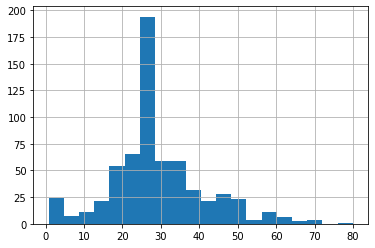

In [9]:
dftrain.age.hist(bins=20)
# Most of the people are in their mid twenties. 
# This could introduce a little bit of bias into the linear correlation graph.

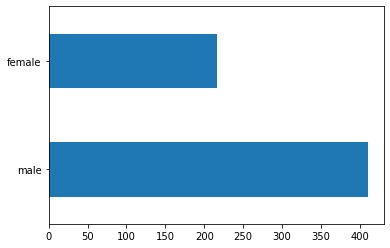

In [12]:
dftrain.sex.value_counts().plot(kind='barh')
# Most of the people are male.

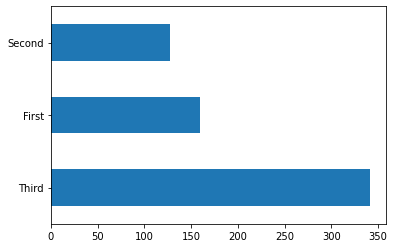

In [14]:
dftrain['class'].value_counts().plot(kind='barh')
# Most of the people are in third class

Text(0.5, 0, '% survive')

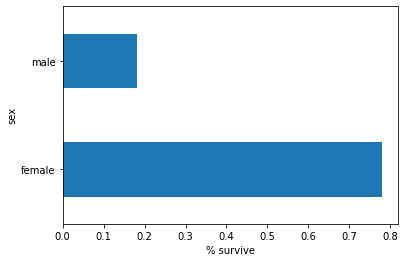

In [20]:
# The precentage survival by sex
pd.concat([dftrain, y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
# Females have a higher chance of survival

### Transform categorical data to numerical data

In [26]:
CATEGORICAL_COLUMMNS=['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
NUMERICAL_COLUMNS=['age','fare']

feature_columns=[]
for feature_name in CATEGORICAL_COLUMMNS:
  vocabularety=dftrain[feature_name].unique() #get a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabularety))

for feature_name in NUMERICAL_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

## Linear Regression model

Linea regression is about predicting numerical value.

We use linear regression when our dataset is correlated linearly.

Example:
* Predicting grades for students, we would assume that if someone has low grade, they will finish with a lower grade, and if they have a high grade they would finish with a higher grade.
* Predicting future life expentancy
If someone is older, they are expected to live not as long.

Baiscally the relationship should be linearly, for example, if some parameter goes up, the other parameter goes up. The magnitude of the relationship (how much one goes down versus how much one goes downn) is what the algorithm will figure out.

### Why is linear regression is suitable for such task ? 
According to the rules applied at that time, if someone is a female, we can assume that they have a higher chance of surviving the titanic.

Regarding the age, we can assume that the younger the person is the more likely to survive. 

Regarding the class, the higher class the person is the more likely to survive.

### Training model

#### How is the data fed to the model ?
The data is loaded through batches. We do not feed the entire dataset to the model, but small batches of entries. We feed these batches to our model mulitplt times according to the number of epochs.

Epochs are how many times the model will see the same data. In each epoch, we feed the data to the model again but with different order. 

Training the model with many epochs may cause overfitting. Hence we can start with small number of epochs and then modify it if we need to go higher.



#### Input function
The input function is the way to define how are data is going to be broke into batches and epochs to be fed to the model.

The function takes the dataset as a dataframe and returns the data as a tf.data.Dataset object, which is a requirement to create the model.

In [27]:
# the outter function makes a input_function and return it as an output
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  # an inner function to create the dataset in a form that meets the requirments
  def input_function(): 
    ds=tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds=ds.shuffle(1000) #randomize order of data
    ds=ds.batch(batch_size).repeat(num_epochs) # split dataset into batches of 32 and repeat process for number of epochs
    return ds
  return input_function
train_input_fn= make_input_fn(dftrain, y_train)
eval_input_fn= make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) # the epoch for validating is 1, and no need to shuffle


#### Creating the model

In [28]:
linear_est=tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0v_j0p35', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#### Training the model

In [29]:
linear_est.train(train_input_fn) # we pass the input_function for the training dataset
result=linear_est.evaluate(eval_input_fn) # getting the metrices of the model by testing
clear_output()   #clears console output
print(result['accuracy']) # as a first shot the accuracy is ok

0.7386364


In [31]:
result

{'accuracy': 0.7386364,
 'accuracy_baseline': 0.625,
 'auc': 0.8335782,
 'auc_precision_recall': 0.7942832,
 'average_loss': 0.48941502,
 'global_step': 200,
 'label/mean': 0.375,
 'loss': 0.4842028,
 'precision': 0.6363636,
 'prediction/mean': 0.4348828,
 'recall': 0.7070707}

#### Predicting

In [33]:
pred_result=list(linear_est.predict(eval_input_fn))
print(pred_result) #a list of all dictionaries of the predicting

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0v_j0p35/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'logits': array([-2.2134395], dtype=float32), 'logistic': array([0.09855008], dtype=float32), 'probabilities': array([0.9014499, 0.0985501], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([0.04961225], dtype=float32), 'logistic': array([0.5124005], dtype=float32), 'probabilities': array([0.48759946, 0.5124005 ], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([1.5066622], dtype=float32), 'logistic': array([0.818566], dtype=float32), 'probabilities': array([0.18143398,

In [34]:
print(pred_result[0])

{'logits': array([-2.2134395], dtype=float32), 'logistic': array([0.09855008], dtype=float32), 'probabilities': array([0.9014499, 0.0985501], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}


In [40]:
print('Person\n', dfeval.loc[0])
print('Predicting results\n',pred_result[0]['probabilities'])
print('Probability of survival',pred_result[0]['probabilities'][1])
print('Probability of non-survival',pred_result[0]['probabilities'][0])
print('Real label, survived or not?', y_eval.loc[0])

Person
 sex                          male
age                          35.0
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
Predicting results
 [0.9014499 0.0985501]
Probability of survival 0.098550096
Probability of non-survival 0.9014499
Real label, survived or not? 0
